In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !ls
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install spark_sklearn

     |████████████████████████████████| 4.9MB 7.6MB/s 
  Created wheel for spark-sklearn: filename=spark_sklearn-0.3.0-cp36-none-any.whl size=30592 sha256=9229b22d8d7eb6fb3d345dbcce1cd05332c8d66f73f58989b7fc650e637c480a
  Stored in directory: /root/.cache/pip/wheels/64/28/e8/cb0250888675c630786f932dcc63ed96ac1aca299bcfb7235f
Successfully built spark-sklearn
ERROR: yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
ERROR: imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.19.2 which is incompatible.
  Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [5]:
#import library

import time
from scipy import stats
import pyspark
from pyspark import SparkContext, SparkConf
sc = pyspark.SparkContext()
import os
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
training = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/training/trainingSet_noEmpty.csv")
testing = pd.read_csv("/content/drive/My Drive/CityU CS/2019-2020 SemB/CS 4514/Dataset/testing/testingSet_noEmpty.csv")

print(training.shape)
print(training.columns)
print()
print(testing.shape)
print(testing.columns)

(2690, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)

(1140, 123)
Index(['Spanish Div', 'Year', 'Month', 'Day', 'FTHG', 'FTAG', 'HTHG', 'HTAG',
       'HS', 'AS',
       ...
       'AwayTeam_Sociedad', 'AwayTeam_Sp Gijon', 'AwayTeam_Valencia',
       'AwayTeam_Valladolid', 'AwayTeam_Vallecano', 'AwayTeam_Villarreal',
       'HTR_A', 'HTR_D', 'HTR_H', 'FTR'],
      dtype='object', length=123)


In [0]:
# Reorder the column in test set so that columns order in both training and testing set can remain consistent
testing = testing[training.columns.values]

In [0]:
# convert back those attribute to int

training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = training[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']] = testing[['Spanish Div','Year','Month','Day','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY',
         'HR','AR']].astype(int)

In [0]:
training.iloc[:,65:122] = training.iloc[:,65:122].astype(int)
testing.iloc[:,65:122] = testing.iloc[:,65:122].astype(int)

In [0]:
training.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)
testing.rename(columns={"BbMx<2.5": "BbMx_less_than_2.5", "BbAv<2.5": "BbAv_less_than_2.5", "BbMx>2.5": "BbMx_more_than_2.5", "BbAv>2.5": "BbAv_more_than_2.5"},inplace = True)

In [11]:
training.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [12]:
testing.iloc[:,49:53].columns.values

array(['BbMx_more_than_2.5', 'BbAv_more_than_2.5', 'BbMx_less_than_2.5',
       'BbAv_less_than_2.5'], dtype=object)

In [0]:
training['FTR'] = training['FTR'].map({'A':0,'D':1,'H':2})
testing['FTR'] = testing['FTR'].map({'A':0,'D':1,'H':2})

In [14]:
print(training.shape)
print(testing.shape)

(2690, 123)
(1140, 123)


In [0]:
# lasso- feature selection
# https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499
# https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

In [0]:
from sklearn.feature_selection import SelectFromModel
#from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
X_train = training.drop('FTHG',axis = 1)
y_train = training['FTHG']

X_test = training.drop('FTHG',axis = 1)
y_test = training['FTHG']

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
from sklearn.feature_selection import SelectKBest, f_classif
sel_ = SelectKBest(f_classif, k=30)
sel_.fit(scaler.transform(X_train),y_train)

SelectKBest(k=30, score_func=<function f_classif at 0x7f445f307268>)

In [20]:
feature_idx = sel_.get_support()
feature_idx

array([False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False, False, False,  True,  True,
        True,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True])

In [21]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
#print('features importance: {}'.format(
#     (sel_.estimator_.feature_importances_)))

total features: 122
selected features: 30


In [22]:
print(selected_feat)

Index(['HTHG', 'HST', 'B365D', 'B365A', 'BWD', 'BWA', 'IWD', 'IWA', 'LBD',
       'LBA', 'WHD', 'WHA', 'SJD', 'SJA', 'VCD', 'VCA', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA', 'BbMx_less_than_2.5', 'BbAv_less_than_2.5', 'BbAHh',
       'PSD', 'PSA', 'PSCD', 'PSCA', 'HomeTeam_Barcelona', 'HTR_H', 'FTR'],
      dtype='object')


In [23]:
feature_name = X_train.columns[feature_idx]
print(feature_name)

Index(['HTHG', 'HST', 'B365D', 'B365A', 'BWD', 'BWA', 'IWD', 'IWA', 'LBD',
       'LBA', 'WHD', 'WHA', 'SJD', 'SJA', 'VCD', 'VCA', 'BbMxD', 'BbAvD',
       'BbMxA', 'BbAvA', 'BbMx_less_than_2.5', 'BbAv_less_than_2.5', 'BbAHh',
       'PSD', 'PSA', 'PSCD', 'PSCA', 'HomeTeam_Barcelona', 'HTR_H', 'FTR'],
      dtype='object')


In [24]:
newXtrain = X_train[feature_name]

newXtrain.shape

(2690, 30)

In [25]:
newXtest = X_test[feature_name]

newXtest.shape

(2690, 30)

In [0]:
import time
from sklearn.ensemble import RandomForestClassifier
import spark_sklearn
from spark_sklearn import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,roc_curve,auc
#import xgboost as xgb

In [0]:
def metrics_calculation(model_name,Y_true,Y_predict):
  #roc=roc_auc_score(Y_true, Y_predict)
  accuracy = accuracy_score(Y_true, Y_predict)
  precision = precision_score(Y_true, Y_predict,average=None)
  recall = recall_score(Y_true, Y_predict,average=None)
  f1 = f1_score(Y_true, Y_predict,average=None)
  metrics=  pd.DataFrame([[model_name,accuracy,precision,recall,f1]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
  return metrics

In [0]:
model_results = []
models = {}
confusion_matrices = []
time_results=[]

In [0]:
# Random Forest Classifier
parameters = {
    "max_depth": [3, None],
    "max_features": [1, 3, 5],
    "min_samples_split": [0.5, 0.9],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10, 20, 40, 80]
}

In [30]:
start = time.time()
gs = spark_sklearn.GridSearchCV(sc,estimator=RandomForestClassifier(), cv=5,param_grid=parameters,n_jobs=-1)
gs.fit(newXtrain, y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("RandomForestClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 301.21542286872864 seconds


[('RandomForestClassifier', 301.21542286872864)]

In [31]:
models['rfc'] = gs
predYtest = gs.predict(newXtest)
model_results.append(metrics_calculation('Random Forest Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns]]

In [32]:
# confusion matrix

#confusion_matrices.append(confusion_matrix(Y_test,predYtest))
#confusion_matrices
print('Random Forest: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("RandomForestClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Random Forest:  [[425 158   0   0   0   0   0   0   0   0]
 [187 520 153   0   0   0   0   0   0   0]
 [ 35 342 284   0   0   0   0   0   0   0]
 [  0 108 231   0   0   0   0   0   0   0]
 [  0  25 134   0   0   0   0   0   0   0]
 [  0   8  53   0   0   0   0   0   0   0]
 [  0   0  18   0   0   0   0   0   0   0]
 [  0   0   5   0   0   0   0   0   0   0]
 [  0   0   3   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]]))]

In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
parameters = {
    'max_depth':[2,4,6,8,10],
    'min_samples_leaf':[2,4,6,8,10], 
    'min_samples_split':[2,4,6,8,10],
    'criterion': ['gini','entropy']
}

In [34]:
start = time.time()
dt = DecisionTreeClassifier()
gs_dt = spark_sklearn.GridSearchCV(sc,estimator=dt,cv=5,param_grid=parameters,n_jobs=-1)
gs_dt.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("DecisionTreeClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 68.75718522071838 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838)]

In [35]:
models['dt'] = gs_dt
predYtest = gs_dt.predict(newXtest)
model_results.append(metrics_calculation('Decision Tree',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns]]

In [36]:
# confusion matrix
print('Decision Tree: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("DecisionTreeClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

Decision Tree:  [[536  47   0   0   0   0   0   0   0   0]
 [245 458 157   0   0   0   0   0   0   0]
 [ 43 211 400   0   6   1   0   0   0   0]
 [  8  47 221  24  31   8   0   0   0   0]
 [  0   1  92  14  34  18   0   0   0   0]
 [  0   0  22   5   8  26   0   0   0   0]
 [  0   0   1   0   4  13   0   0   0   0]
 [  0   0   0   0   0   5   0   0   0   0]
 [  0   0   0   0   0   3   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [0]:
# KNN Classifier
parameters = {
    'n_neighbors': [3,5,10],
}

In [38]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
knn = KNeighborsClassifier()
gs_knn = spark_sklearn.GridSearchCV(sc,estimator=knn,cv=5,param_grid=parameters,n_jobs=-1)
gs_knn.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("KNeighborsClassifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 2.658781051635742 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838),
 ('KNeighborsClassifier', 2.658781051635742)]

In [39]:
models['knn'] = gs_knn
predYtest = gs_knn.predict(newXtest)
model_results.append(metrics_calculation('KNN Classifier',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
 
 [1 rows x 5 columns]]

In [40]:
# confusion matrix
print('KNN Classifier: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

KNN Classifier:  [[490  77  10   5   1   0   0   0   0   0]
 [218 515  98  26   3   0   0   0   0   0]
 [ 41 210 339  60   7   4   0   0   0   0]
 [  4  70 127 116  18   4   0   0   0   0]
 [  0  14  57  47  38   3   0   0   0   0]
 [  0   6  12  25  10   8   0   0   0   0]
 [  0   0   4   6   5   3   0   0   0   0]
 [  0   0   0   2   3   0   0   0   0   0]
 [  0   1   1   0   1   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [0]:
# Logistic Regression
parameters = {
  'C': [0.001, 0.01, 0.1, 1, 10], 
  'class_weight': [None, 'balanced'], 
  'penalty': ['l1', 'l2']
}

In [42]:
from sklearn.linear_model import LogisticRegression
start = time.time()
lr = LogisticRegression()
gs_lr = spark_sklearn.GridSearchCV(sc,estimator=lr,param_grid = parameters,cv=5,n_jobs=-1)
gs_lr.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("LogisticRegression",finish - start))
time_results

Time required to do Parallel Grid Search CV: 189.62452626228333 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838),
 ('KNeighborsClassifier', 2.658781051635742),
 ('LogisticRegression', 189.62452626228333)]

In [43]:
models['lr'] = gs_lr
predYtest = gs_lr.predict(newXtest)
model_results.append(metrics_calculation('Logistic Regression',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.7318217357310399, 0.570446735395189, 0.5078...
 
 [1 rows x 5 columns]]

In [44]:
# Confusion Matrix
print('Logistic Regression: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("LogisticRegression",confusion_matrix(y_test,predYtest)))
confusion_matrices

Logistic Regression:  [[468 114   1   0   0   0   0   0   0   0]
 [193 498 166   2   0   1   0   0   0   0]
 [ 31 213 390  24   3   0   0   0   0   0]
 [  4  54 202  66   7   4   2   0   0   0]
 [  0   6  94  34  23   2   0   0   0   0]
 [  0   1  22  10  14  13   1   0   0   0]
 [  0   0   0   4   6   2   6   0   0   0]
 [  0   0   0   1   2   0   0   2   0   0]
 [  0   0   0   1   1   0   0   0   1   0]
 [  0   0   0   0   1   0   0   0   0   0]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [0]:
# SGD
parameters = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0], 
  'class_weight': [None, 'balanced']
}

In [46]:
from sklearn.linear_model import SGDClassifier
start = time.time()
sgd = SGDClassifier(loss="hinge")
gs_sgd = spark_sklearn.GridSearchCV(sc,estimator=sgd,param_grid = parameters,cv=5,n_jobs=-1)
gs_sgd.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SGD Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 3.985771894454956 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838),
 ('KNeighborsClassifier', 2.658781051635742),
 ('LogisticRegression', 189.62452626228333),
 ('SGD Classifier', 3.985771894454956)]

In [47]:
models['sgd'] = gs_sgd
predYtest = gs_sgd.predict(newXtest)
model_results.append(metrics_calculation('SGD',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.7318217357310399, 0.570446735395189, 0.5078...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5021645021645021, 0.006912442396313364, 0.4...
 
 [1 rows x 5 columns]]

In [48]:
# Confusion Matrix
print('SGD: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SGDClassifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SGD:  [[580   0   3   0   0   0   0   0   0   0]
 [709   3 145   0   0   0   0   0   0   3]
 [331   1 320   1   0   0   0   0   0   8]
 [ 90   2 227   0   0   0   0   0   0  20]
 [ 12   2 109   1   0   0   0   0   0  35]
 [  5   0  26   1   0   3   0   0   0  26]
 [  0   0   3   1   0   0   0   0   0  14]
 [  0   0   0   0   0   0   0   0   0   5]
 [  0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   1]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [0]:
# SVM (rbf)
parameters = [
   {'kernel': ['rbf'], 'gamma': [ 1, 1e-2 , 1e-4],
   'C': [1, 10, 100]},
]

In [50]:
from sklearn import svm
start = time.time()
svc = svm.SVC(probability=True)
gs_svc = spark_sklearn.GridSearchCV(sc,estimator=svc,param_grid = parameters,cv=5,n_jobs=-1)
gs_svc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("SVM (rbf)",finish - start))
time_results

Time required to do Parallel Grid Search CV: 112.42909216880798 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838),
 ('KNeighborsClassifier', 2.658781051635742),
 ('LogisticRegression', 189.62452626228333),
 ('SGD Classifier', 3.985771894454956),
 ('SVM (rbf)', 112.42909216880798)]

In [80]:
models['svm'] = gs_svc
redYtest = gs_svc.predict(newXtest)
model_results.append(metrics_calculation('SVM',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.7318217357310399, 0.570446735395189, 0.5078...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5021645021645021, 0.006912442396313364, 0.4...
 
 [1 rows x 5 columns],
        Model  ...                                           F1 Score
 0  SVM (rbf)  ...  [0.5021645021645021, 0.0069

In [52]:
# Confusion Matrix
print('SVM: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("SVM Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

SVM (rbf):  [[580   0   3   0   0   0   0   0   0   0]
 [709   3 145   0   0   0   0   0   0   3]
 [331   1 320   1   0   0   0   0   0   8]
 [ 90   2 227   0   0   0   0   0   0  20]
 [ 12   2 109   1   0   0   0   0   0  35]
 [  5   0  26   1   0   3   0   0   0  26]
 [  0   0   3   1   0   0   0   0   0  14]
 [  0   0   0   0   0   0   0   0   0   5]
 [  0   0   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0   0   0   1]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [0]:
#XGBoost
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
#https://www.datacamp.com/community/tutorials/xgboost-in-python

parameters = [
    {'objective': ['reg:logistic'],
     'learning_rate': [0.01, 0.05, 0.1],
     'n_estimators': [10, 20, 40, 80],
     'max_depth': [3,5,10],
     'gamma': [1,3,5,10],
     'colsample_bytree': [0.3, 0.5, 0.8]},
]

In [74]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
#from sklearn.cross_validation import *
from sklearn.model_selection import GridSearchCV

start = time.time()
xgb_model = xgb.XGBClassifier()
#gs_xgbc = spark_sklearn.GridSearchCV(sc,estimator=xgbc,param_grid = parameters,cv=5,n_jobs=-1)
xgbc = GridSearchCV(estimator=xgb_model,param_grid = parameters,cv=5,n_jobs=-1)
xgbc.fit(newXtrain,y_train)
finish = time.time()
print('Time required to do Parallel Grid Search CV: {} seconds'.format(finish - start))
time_results.append(("XGBoost Classifier",finish - start))
time_results

Time required to do Parallel Grid Search CV: 1689.2536535263062 seconds


[('RandomForestClassifier', 301.21542286872864),
 ('DecisionTreeClassifier', 68.75718522071838),
 ('KNeighborsClassifier', 2.658781051635742),
 ('LogisticRegression', 189.62452626228333),
 ('SGD Classifier', 3.985771894454956),
 ('SVM (rbf)', 112.42909216880798),
 ('SVM (rbf)', 35.44483280181885),
 ('XGBoost Classifier', 1689.2536535263062)]

In [75]:
models['xgbc'] = xgbc
predYtest = xgbc.predict(newXtest)
model_results.append(metrics_calculation('XGBC',y_test,predYtest))
model_results

[                      Model  ...                                           F1 Score
 0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
 
 [1 rows x 5 columns],
            Model  ...                                           F1 Score
 0  Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
 
 [1 rows x 5 columns],
             Model  ...                                           F1 Score
 0  KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
 
 [1 rows x 5 columns],
                  Model  ...                                           F1 Score
 0  Logistic Regression  ...  [0.7318217357310399, 0.570446735395189, 0.5078...
 
 [1 rows x 5 columns],
   Model  ...                                           F1 Score
 0   SGD  ...  [0.5021645021645021, 0.006912442396313364, 0.4...
 
 [1 rows x 5 columns],
        Model  ...                                           F1 Score
 0  SVM (rbf)  ...  [0.5021645021645021, 0.0069

In [76]:
# Confusion Matrix
print('XGBC: ', confusion_matrix(y_test,predYtest))
confusion_matrices.append(("XGBoost Classifier",confusion_matrix(y_test,predYtest)))
confusion_matrices

XGBC:  [[565  18   0   0   0   0   0   0   0   0]
 [278 449 132   1   0   0   0   0   0   0]
 [ 49 202 395  12   2   1   0   0   0   0]
 [  8  42 220  57   8   4   0   0   0   0]
 [  0   3  82  47  20   5   2   0   0   0]
 [  0   0  19   9  10  23   0   0   0   0]
 [  0   0   0   3   2   5   8   0   0   0]
 [  0   0   0   0   2   2   0   1   0   0]
 [  0   0   0   0   0   1   0   0   2   0]
 [  0   0   0   0   0   1   0   0   0   0]]


[('RandomForestClassifier',
  array([[425, 158,   0,   0,   0,   0,   0,   0,   0,   0],
         [187, 520, 153,   0,   0,   0,   0,   0,   0,   0],
         [ 35, 342, 284,   0,   0,   0,   0,   0,   0,   0],
         [  0, 108, 231,   0,   0,   0,   0,   0,   0,   0],
         [  0,  25, 134,   0,   0,   0,   0,   0,   0,   0],
         [  0,   8,  53,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,  18,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   5,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   1,   0,   0,   0,   0,   0,   0,   0]])),
 ('DecisionTreeClassifier',
  array([[536,  47,   0,   0,   0,   0,   0,   0,   0,   0],
         [245, 458, 157,   0,   0,   0,   0,   0,   0,   0],
         [ 43, 211, 400,   0,   6,   1,   0,   0,   0,   0],
         [  8,  47, 221,  24,  31,   8,   0,   0,   0,   0],
         [  0,   1,  92,  14,  34,  18,   0,   0,   0,   0],
         [  0,   0,  22,  

In [81]:
# combine dataframes, each dataframe store the metrics of each classifier

df1 = pd.DataFrame(model_results[0])
df2 = pd.DataFrame(model_results[1])
df3 = pd.DataFrame(model_results[2])
df4 = pd.DataFrame(model_results[3])
df5 = pd.DataFrame(model_results[4])
df6 = pd.DataFrame(model_results[5])
df8 = pd.DataFrame(model_results[7])
frames = [df1, df2, df3, df4, df5, df6, df8]
result = pd.concat(frames)
result

Model  ...                                           F1 Score
0  Random Forest Classifier  ...  [0.6910569105691058, 0.5145967342899554, 0.368...
0             Decision Tree  ...  [0.7575971731448765, 0.5640394088669952, 0.514...
0            KNN Classifier  ...  [0.7335329341317365, 0.5875641756988021, 0.517...
0       Logistic Regression  ...  [0.7318217357310399, 0.570446735395189, 0.5078...
0                       SGD  ...  [0.5021645021645021, 0.006912442396313364, 0.4...
0                 SVM (rbf)  ...  [0.5021645021645021, 0.006912442396313364, 0.4...
0                      XGBC  ...  [0.7619689817936615, 0.5705209656925032, 0.523...

[7 rows x 5 columns]

No handles with labels found to put in legend.


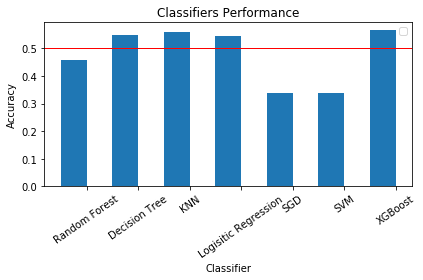

In [82]:
# plot accuracy bar chart

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['Random Forest', 'Decision Tree', 'KNN', 'Logisitic Regression', 'SGD', 'SVM','XGBoost']
accuracy = result['Accuracy']

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels,rotation = 35)
ax.set_title('Classifiers Performance')
ax.legend()

plt.axhline(y=0.5,linewidth=1, color='r')

fig.tight_layout()

plt.show()